In [30]:
import RNA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from Bio.Seq import Seq
from Bio import motifs
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D


%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

## Data Loading and Preparation

In [48]:
def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

In [32]:
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000] #these are the 20k with the HIGHEST READ COUNT
e_train = df.iloc[20000:]

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
# LAE: added .values before reshape due to pandas naming deprecation
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

label_e_train = e_train['scaled_rl']
label_e_test = e_test['rl']

## Construct Model

Use a more compact model than the authors' original, but ideally still reasonable r2 values

In [33]:
def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dilation1=3, dilation2=1, dilation3=1, 
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), dilation_rate=dilation1,
                         padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), dilation_rate=dilation2,
                         padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), dilation_rate=dilation3, 
                         padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model

In [34]:
# model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3, border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=15, filter_len=8,
#                     dilation1=1, dilation2=4,
#                     dropout1=0, dropout2=0,dropout3=0.2)

W0823 22:28:05.126591 4450448832 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 22:28:05.162580 4450448832 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 22:28:05.170793 4450448832 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 22:28:05.276021 4450448832 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0823 22:28:05.284399 4450448832 deprecati

Epoch 1/3
260000/260000 [==============================] - 21s 82us/step - loss: 0.3784
Epoch 2/3
260000/260000 [==============================] - 19s 75us/step - loss: 0.2210
Epoch 3/3
260000/260000 [==============================] - 19s 72us/step - loss: 0.1685


In [35]:
e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print 'r-squared = ', r

r-squared =  0.9143350584632816


In [37]:
# Save model
name = 'base_efficient_CNN_model.hdf5'
model.save('./saved_models/'+name)

## What happens if we visualize model performance on ALL the data, not just the test set?

In [145]:
model = keras.models.load_model('./saved_models/main_MRL_model.hdf5')

In [146]:
# Test Dataset
e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print 'r-squared = ', r

r-squared =  0.9338504476208073


In [148]:
# Entire Dataset
data = pd.read_csv('../mfe_dataset.csv')
seq_data = one_hot_encode(data,seq_len=50)
data = test_data(df=data, model=model, obs_col='rl',test_seq=seq_data)

In [149]:
r = r2(data['rl'], data['pred'])
print 'r-squared = ', r

r-squared =  0.8996725996764278


In [151]:
# Train Dataset
e_train = test_data(df=e_train, model=model, obs_col='rl', test_seq=seq_e_train)
r = r2(e_train['rl'], e_train['pred'])
print 'r-squared = ', r

r-squared =  0.8941933452903729


Train is blue, Test is red


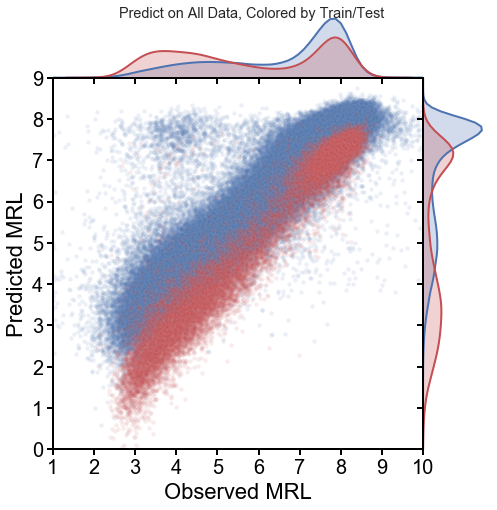

In [153]:
# atg = data[data['utr'].apply(lambda x: 'ATG' in x)]
# n_atg = data[data['utr'].apply(lambda x: 'ATG' not in x)]
# print "Number of utrs with ATG:", len(atg)
# print "Number of utrs without ATG:", len(n_atg)

c1 = (0.3, 0.45, 0.69)

c2 = 'r'
g = sns.JointGrid(x='rl', y="pred", data=e_train, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha='0.1', edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(0,9.01, 1));
ax.set_yticklabels(range(10),size=20);
ax.set_xticks(np.arange(1,10.01, 1));
ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(0,9)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = e_test['rl'].values
g.y = e_test['pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha='0.1', color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig
f.suptitle("Predict on All Data, Colored by Train/Test")
print "Train is blue, Test is red"

In [142]:
data_ods = data[(data['rl'] / data['pred'] < 0.75) | (data['rl'] / data['pred'] > 1.25)]
len(data_ods)

6155

In [159]:
d = df[df['utr'].isin(data_ods['utr'].values)]
print  np.mean(d['total_reads']), 'full dataset off-diagonal average read count'
print np.mean(e_test['total_reads']), 'test dataset average read count'
print np.mean(e_train['total_reads']), 'train dataset average read count'
print np.mean(e_test[e_test['utr'].isin(data_ods['utr'].values)]['total_reads']), 'test dataset off-diagonal average read count'
# Okay, off-diagonals are NOT there just for lack of reads. good to know

1100.1990251827783 full dataset off-diagonal average read count
3185.96415 test dataset average read count
1070.73505 train dataset average read count
3334.3046728971963 test dataset off-diagonal average read count


### Okay, so what's special about these points?  I could do the same off-diagonal analysis as before, only now with this full set of 6000 points instead of only 50...

( Should I redo this with the author's model before proceeding, instead of my basic one? probably...?)

In [143]:
data_ods.to_csv('../author_off_diagonal_from_full_dataset.csv')

### Calculate/Load MFE and Stratify Dataset

In [8]:
get_mfe = lambda s: RNA.fold(s)[1]
upstream_constant = "GGGACATCGTAGAGAGTCGTACTTA"
eGFP = "ATGGGCGAATTAAGTAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCAAGCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTTCGAATAAAGCTAGC"
downstream_addition = "GCCTCGACTGTGCCTTCTAGTTGCCAGCCATCTGTTGTTTG"

def get_start_subseq(utr,n_bp=75):
    seq = upstream_constant+utr+eGFP+downstream_addition
    return seq[:min(n_bp,len(seq))]

In [9]:
# data = pd.DataFrame([df['utr'],df['rl']]).transpose()

# data['scaled_rl'] = preprocessing.StandardScaler().fit_transform(data['rl'].values.reshape(-1,1))
# print 'finished rescale'
# data['mfe75'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,75))) #just constant region + random region
# print 'finished 75'
# data['mfe100'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,100)))
# print 'finished 100'
# data['mfe125'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,125)))
# print 'finished 125'

# data.to_csv('../mfe_dataset.csv')

data = pd.read_csv('../mfe_dataset.csv')

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


finished rescale
finished 75
finished 100
finished 125


In [12]:
data.head(3)

,utr,rl,scaled_rl,mfe75,mfe100,mfe125
0,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA,3.03994,-2.130922,-16.0,-24.700001,-34.799999
1,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT,3.89511,-1.600332,-14.4,-25.600000,-36.400002
2,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGACGCGA,3.33452,-1.948147,-12.6,-20.200001,-30.500000


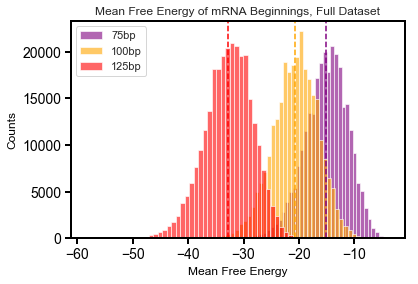

In [15]:
fig,ax = plt.subplots()
ax.hist(data['mfe75'].values,color='purple',bins=50,alpha=0.6,label='75bp')
ax.axvline(np.mean(data['mfe75'].values),color='purple',linestyle="--")
ax.hist(data['mfe100'].values,color='orange',bins=50,alpha=0.6,label='100bp')
ax.axvline(np.mean(data['mfe100'].values),color='orange',linestyle="--")
ax.hist(data['mfe125'].values,color='red',bins=50,alpha=0.6,label='125bp')
ax.axvline(np.mean(data['mfe125'].values),color='red',linestyle="--")
ax.set_title("Mean Free Energy of mRNA Beginnings, Full Dataset")
ax.set_xlabel('Mean Free Energy')
ax.set_ylabel("Counts")
ax.legend()

In [73]:
# Stratify based on the 75bp MFE 
data.sort_values('mfe75',inplace=True,ascending=False)
data.reset_index(inplace=True,drop=True)

highest_qt = data.iloc[:70000] #these have the least negative/highest MFE => least 2ndary structure
nexthigh_qt = data.iloc[70000:140000]
nextlow_qt = data.iloc[140000:21000]
lowest_qt = data.iloc[210000:] #these have the lowest MFE => highest 2ndary structure

high_half = data.iloc[:140000]
low_half = data.iloc[140000:]

In [74]:
data.head(3)

,index,utr,rl,scaled_rl,mfe75,mfe100,mfe125
0,203015,CAGCTACCAATAAACGCAAAACATATCAACACTACATAAGAGAGTCAGAC,7.6586,0.734722,-3.5,-8.5,-21.0
1,258923,CCAACAGATTAACGGAGAACTAAAACGCATAGATATATAATAAAAGATTT,7.58116,0.686676,-3.5,-10.1,-22.6
2,278314,AATTGAGCAAACAGAAGGAATAATTGGGAAGGAAAAAAAGTTAATAGTGT,7.40824,0.579390,-3.5,-12.2,-22.5


In [93]:
# Shuffle the datasets before splitting between train and test
np.random.seed(1337)
high_half.sample(frac=1).reset_index(drop=True)
low_half.sample(frac=1).reset_index(drop=True)

high_train = high_half.iloc[:120000]
high_test = high_half.iloc[120000:]
low_train = low_half.iloc[:120000]
low_test = low_half.iloc[120000:]

seq_high_train = one_hot_encode(high_train,seq_len=50)
seq_low_train = one_hot_encode(low_train, seq_len=50)
seq_high_test = one_hot_encode(high_test,seq_len=50)
seq_low_test = one_hot_encode(low_test, seq_len=50)

In [94]:
np.random.seed(1337)
high_model = train_model(seq_high_train, high_train['scaled_rl'], nb_epoch=5, border_mode='same',
                    inp_len=50, nodes=40, layers=3, nbr_filters=40, filter_len=8,
                    dilation1=1, dilation2=4,
                    dropout1=0, dropout2=0,dropout3=0.2)

Epoch 1/5
120000/120000 [==============================] - 23s 192us/step - loss: 0.4394
Epoch 2/5
120000/120000 [==============================] - 21s 174us/step - loss: 0.2046
Epoch 3/5
120000/120000 [==============================] - 20s 168us/step - loss: 0.1627
Epoch 4/5
120000/120000 [==============================] - 21s 173us/step - loss: 0.1466
Epoch 5/5
120000/120000 [==============================] - 19s 162us/step - loss: 0.1384


In [95]:
high_test = test_data(df=high_test, model=high_model, obs_col='rl',test_seq=seq_high_test,output_col='high_pred')
r = r2(high_test['rl'].astype('float'), high_test['high_pred'].astype('float')) #not sure why typecast is needed?
print 'high model/high mfe r-squared = ', r

high model/high mfe r-squared =  0.8832788744751205


In [96]:
low_test = test_data(df=low_test, model=high_model, obs_col='rl',test_seq=seq_low_test,output_col='high_pred')
r = r2(low_test['rl'].astype('float'), low_test['high_pred'].astype('float')) #not sure why typecast is needed?
print 'high model/low mfe r-squared = ', r

high model/low mfe r-squared =  0.8390134775421996


In [97]:
np.random.seed(1337)
low_model = train_model(seq_low_train, low_train['scaled_rl'], nb_epoch=5, border_mode='same',
                    inp_len=50, nodes=40, layers=3, nbr_filters=40, filter_len=8,
                    dilation1=1, dilation2=4,
                    dropout1=0, dropout2=0,dropout3=0.2)

Epoch 1/5
120000/120000 [==============================] - 21s 176us/step - loss: 0.4210
Epoch 2/5
120000/120000 [==============================] - 21s 173us/step - loss: 0.2115
Epoch 3/5
120000/120000 [==============================] - 21s 175us/step - loss: 0.1728
Epoch 4/5
120000/120000 [==============================] - 23s 194us/step - loss: 0.1542
Epoch 5/5
120000/120000 [==============================] - 23s 190us/step - loss: 0.1444


In [98]:
high_test = test_data(df=high_test, model=low_model, obs_col='rl',test_seq=seq_high_test,output_col='low_pred')
r = r2(high_test['rl'].astype('float'), high_test['low_pred'].astype('float')) #not sure why typecast is needed?
print 'low model/high mfe r-squared = ', r

low model/high mfe r-squared =  0.883381494370475


In [99]:
low_test = test_data(df=low_test, model=low_model, obs_col='rl',test_seq=seq_low_test,output_col='low_pred')
r = r2(low_test['rl'].astype('float'), low_test['low_pred'].astype('float')) #not sure why typecast is needed?
print 'low model/low mfe r-squared = ', r

low model/low mfe r-squared =  0.8470064846920721


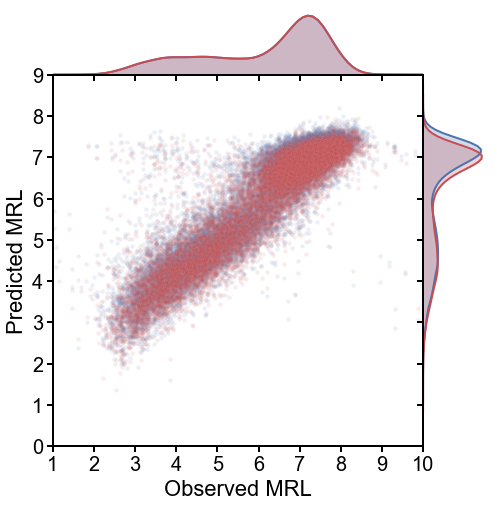

In [101]:
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='rl', y="high_pred", data=low_test, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha='0.1', edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(0,9.01, 1));
ax.set_yticklabels(range(10),size=20);
ax.set_xticks(np.arange(1,10.01, 1));
ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(0,9)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = low_test['rl'].values
g.y = low_test['low_pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha='0.1', color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig

In [107]:
seq_lowest_test = one_hot_encode(lowest_qt,seq_len=50)
seq_highest_test = one_hot_encode(highest_qt,seq_len=50)

lowest_test = test_data(df=lowest_qt, model=high_model, obs_col='rl',test_seq=seq_lowest_test,output_col='high_pred')
r = r2(lowest_test['rl'].astype('float'), lowest_test['high_pred'].astype('float')) #not sure why typecast is needed?
print 'high model/lowest quartile mfe r-squared = ', r

high model/lowest quartile mfe r-squared =  0.8589293992375358


In [105]:
lowest_test = test_data(df=lowest_qt, model=low_model, obs_col='rl',test_seq=seq_lowest_test,output_col='low_pred')
r = r2(lowest_test['rl'].astype('float'), lowest_test['low_pred'].astype('float')) #not sure why typecast is needed?
print 'low model/lowest quartile mfe r-squared = ', r

low model/lowest quartile mfe r-squared =  0.8743078731739669


Text(0.5,0.98,'Testing High- and Low-Trained Models Against Lowest MFE Quartile Data')

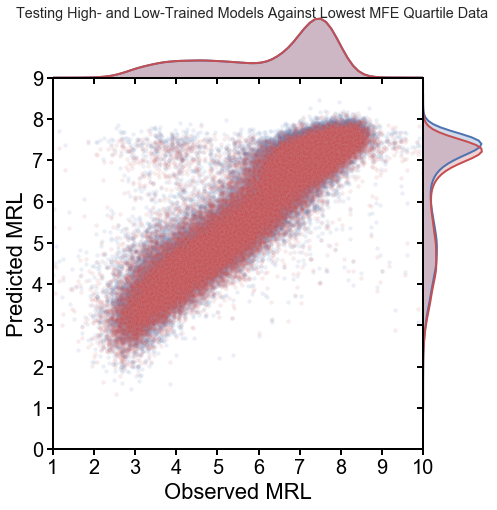

In [110]:
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='rl', y="high_pred", data=lowest_test, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha='0.1', edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(0,9.01, 1));
ax.set_yticklabels(range(10),size=20);
ax.set_xticks(np.arange(1,10.01, 1));
ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(0,9)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = lowest_test['rl'].values
g.y = lowest_test['low_pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha='0.1', color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig
f.suptitle("Testing High- and Low-Trained Models Against Lowest MFE Quartile Data")

## Observations

I still see a lot of off-diagonals. I have questions
- do the shared off-diagonals from previously get better predicted by the low-trained model than the high-trained model?
- are there more off-diagonals when testing the lowest MFE quartile vs the highest MFE quartile? (see below)

In [108]:
highest_test = test_data(df=highest_qt, model=high_model, obs_col='rl',test_seq=seq_highest_test,output_col='high_pred')
r = r2(highest_test['rl'].astype('float'), highest_test['high_pred'].astype('float')) #not sure why typecast is needed?
print 'high model/highest quartile mfe r-squared = ', r

high model/highest quartile mfe r-squared =  0.9055199703977513


In [109]:
highest_test = test_data(df=highest_qt, model=low_model, obs_col='rl',test_seq=seq_highest_test,output_col='low_pred')
r = r2(highest_test['rl'].astype('float'), highest_test['low_pred'].astype('float')) #not sure why typecast is needed?
print 'low model/highest quartile mfe r-squared = ', r

low model/highest quartile mfe r-squared =  0.8900746656490613


Text(0.5,0.98,'Testing High- and Low-Trained Models Against Highest MFE Quartile Data')

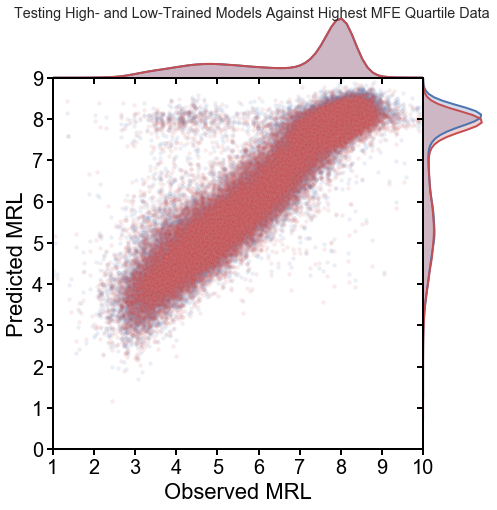

In [112]:
g = sns.JointGrid(x='rl', y="high_pred", data=highest_test, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha='0.1', edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(0,9.01, 1));
ax.set_yticklabels(range(10),size=20);
ax.set_xticks(np.arange(1,10.01, 1));
ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(0,9)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = highest_test['rl'].values
g.y = highest_test['low_pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha='0.1', color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig
f.suptitle("Testing High- and Low-Trained Models Against Highest MFE Quartile Data")

### Answer: off-diagonals pattern looks consistent whether showing highest MFE data or lowest MFE quartile data. 

In [136]:
shared_ods = pd.read_csv('../off_diagonal_utrs_shared.csv')
seq_ods = one_hot_encode(shared_ods,seq_len=50)
shared_ods.head(2)

,Unnamed: 0,utr,0,1,2,3,4,5,6,7,...,r8,r9,r10,r11,r12,r13,rl,pred_50bp,pred_auth,pred_rnn
0,0,AAACGCGGTGGATCACGGCCAGCTAGAGGGCGAAGGCGTCCTTCCACCAG,0.000031,0.000027,0.000013,0.000009,0.000007,0.000004,0.000003,0.000003,...,0.030310,0.017522,0.033050,0.033050,0.026678,0.034121,3.237970,5.849938,5.670214,6.179446
1,1,ACAAAAACATTGACATGATCGGATACAGGCGGCGTACGGCATGCGCTACC,0.000030,0.000032,0.000024,0.000016,0.000008,0.000007,0.000004,0.000004,...,0.025049,0.024521,0.045485,0.045485,0.032901,0.031797,3.715876,6.207780,5.623970,6.539258


In [115]:
shared_ods = test_data(df=shared_ods, model=high_model, obs_col='rl',test_seq=seq_ods,output_col='pred_hi')
r = r2(shared_ods['rl'].astype('float'), shared_ods['pred_hi'].astype('float')) #not sure why typecast is needed?
print 'high model/off-diagonals r-squared = ', r

high model/off-diagonals r-squared =  0.007826821087398584


In [116]:
shared_ods = test_data(df=shared_ods, model=low_model, obs_col='rl',test_seq=seq_ods,output_col='pred_low')
r = r2(shared_ods['rl'].astype('float'), shared_ods['pred_low'].astype('float')) #not sure why typecast is needed?
print 'low model/off-diagonals r-squared = ', r

low model/off-diagonals r-squared =  0.025556410972587484


Text(0.5,0.98,'Testing High- and Low-Trained Models Against Highest MFE Quartile Data')

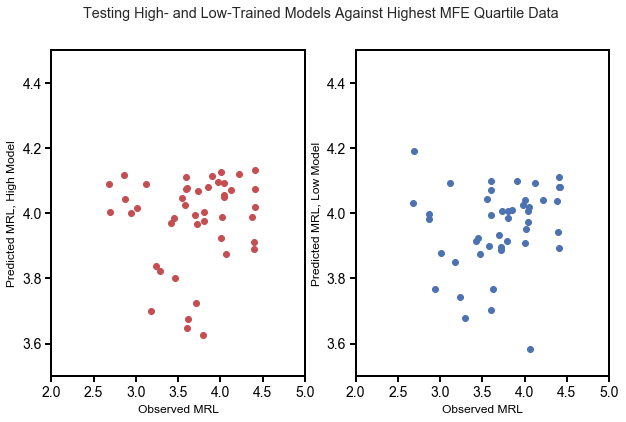

In [123]:
f,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
ax1.scatter(shared_ods['rl'],shared_ods['pred_hi'],color='r')
ax2.scatter(shared_ods['rl'],shared_ods['pred_low'],color='b')
ax1.set_xlabel("Observed MRL")
ax2.set_xlabel("Observed MRL")
ax1.set_ylabel("Predicted MRL, High Model")
ax2.set_ylabel("Predicted MRL, Low Model")
ax1.set_xlim(2,5)
ax2.set_xlim(2,5)
ax1.set_ylim(3.5,4.5)
ax2.set_ylim(3.5,4.5)
f.suptitle("Testing High- and Low-Trained Models Against Highest MFE Quartile Data")

In [124]:
# See, the low model isn't really that much more "linelike" looking, despite the rsquared being ~2x as high...

In [126]:
low_test_ods = low_test[(low_test['rl'] / low_test['low_pred'] < 0.75) | (low_test['rl'] / low_test['low_pred'] > 1.25)]
len(low_test_ods)

626

In [127]:
high_test_ods = high_test[(high_test['rl'] / high_test['high_pred'] < 0.75) 
                          | (high_test['rl'] / high_test['high_pred'] > 1.25)]
len(high_test_ods)

572

1198